3.3 Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии
Сравнить методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на реальных данных.

В качестве реальных данных используйте следующие три набора с сайта LIBSVM http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/. : w8a, gisette и real-sim. Коэффициент регуляризации взять стандартным образом: λ=1/m . Параметры обоих методов взять равными параметрам по умолчанию. Начальную точку выбрать x0=0 .

Построить графики сходимости следующих двух видов:

Зависимость значения функции от реального времени работы метода. Зависимость относительного квадрата нормы градиента ∥∇f(xk)∥22/∥∇f(x0)∥22 (в логарифмической шкале) против реального времени работы. При этом оба метода (градиентный спуск и Ньютон) нужно рисовать на одном и том же графике. Укажите в отчете, какова стоимость итерации и сколько памяти требуется каждому из методов в зависимости от параметров m (размер выборки) и n (размерность пространства). При оценке используйте нотацию O(⋅) , скрывающую внутри себя абсолютные константы.

Какие выводы можно сделать по результатам этого эксперимента? Какой из методов лучше и в каких ситуациях?

Рекомендация: Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в фор- мате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию load_svmlight_file из модуля sklearn.datasets. Обратите внимание, что эта функция возвращает матрицу в формате scipy.sparse.csr_matrix, поэтому Ваша реализация логистического оракула должна поддерживать такие матрицы.


=== Experiment on w8a ===
Dataset w8a not found, using built-in datasets...
Dataset: w8a
Samples: 5000, Features: 54
Regularization: λ = 0.000200
Running Gradient Descent...
Error processing w8a: operands could not be broadcast together with shapes (581012,) (5000,) 

=== Experiment on gisette ===
Dataset gisette not found, using built-in datasets...
Dataset: gisette
Samples: 1000, Features: 500
Regularization: λ = 0.001000
Running Gradient Descent...


Traceback (most recent call last):
  File "/tmp/ipython-input-2221127459.py", line 243, in <cell line: 0>
    history_gd, history_nt = run_experiment(dataset)
                             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2221127459.py", line 192, in run_experiment
    x_gd, history_gd = gradient_descent(oracle, x0, max_iter=50)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2221127459.py", line 57, in gradient_descent
    'func': [oracle.func(x)],
            ^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2221127459.py", line 19, in func
    loss = np.sum(np.logaddexp(0, -self.b * z))
                                  ~~~~~~~~^~~
ValueError: operands could not be broadcast together with shapes (581012,) (5000,) 


Running Newton Method...


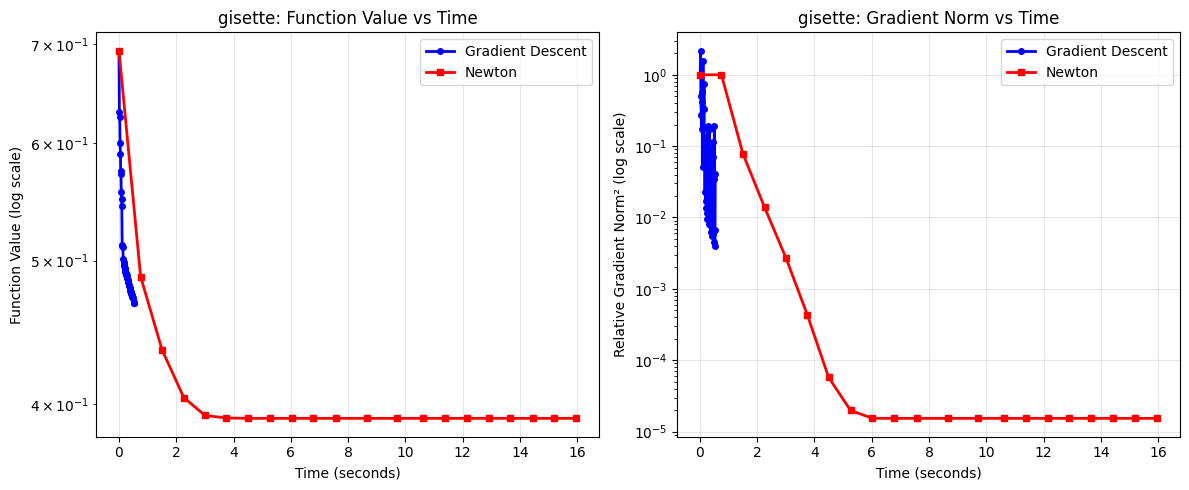


--- Results for gisette ---
Gradient Descent: 50 iterations, final f(x) = 0.467901
Newton Method: 20 iterations, final f(x) = 0.391256

--- Computational Complexity ---
Gradient Descent per iteration: O(mn) time, O(n) memory
Newton Method per iteration: O(mn² + n³) time, O(n²) memory

=== Experiment on real-sim ===
Dataset real-sim not found, using built-in datasets...
Dataset: real-sim
Samples: 11314, Features: 1000
Regularization: λ = 0.000088
Running Gradient Descent...
Running Newton Method...


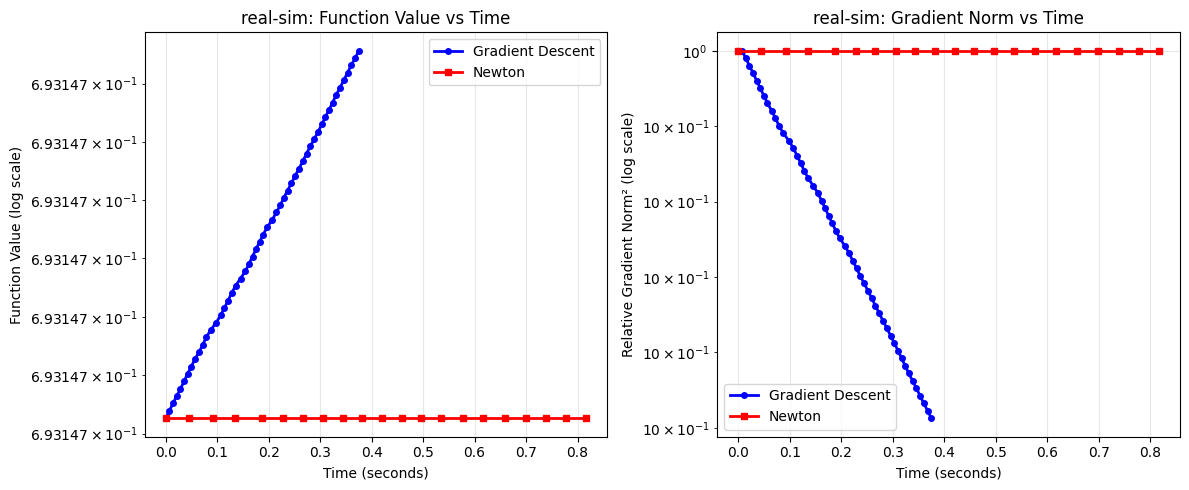


--- Results for real-sim ---
Gradient Descent: 50 iterations, final f(x) = 0.693147
Newton Method: 20 iterations, final f(x) = 0.693147

--- Computational Complexity ---
Gradient Descent per iteration: O(mn) time, O(n) memory
Newton Method per iteration: O(mn² + n³) time, O(n²) memory


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import fetch_covtype, fetch_20newsgroups_vectorized
from scipy.sparse import csr_matrix
from scipy.special import expit
import time
import os

class LogRegL2Oracle:
    def __init__(self, A, b, regcoef):
        self.A = A
        self.b = b
        self.regcoef = regcoef
        self.n = A.shape[0]

    def func(self, x):
        z = self.A.dot(x)
        loss = np.sum(np.logaddexp(0, -self.b * z))
        reg = 0.5 * self.regcoef * np.dot(x, x)
        return (loss / self.n) + reg

    def grad(self, x):
        z = self.A.dot(x)
        y_pred = expit(z)
        grad_data = (y_pred - self.b) / self.n

        if isinstance(self.A, csr_matrix):
            grad = self.A.T.dot(grad_data)
        else:
            grad = self.A.T.dot(grad_data)

        grad += self.regcoef * x
        return grad

    def hess(self, x):
        z = self.A.dot(x)
        y_pred = expit(z)
        weights = y_pred * (1 - y_pred) / self.n

        if isinstance(self.A, csr_matrix):
            # Для разреженных матриц используем эффективное вычисление
            weights_sqrt = np.sqrt(weights)
            A_weighted = self.A.multiply(weights_sqrt[:, np.newaxis])
            hessian = A_weighted.T.dot(A_weighted).toarray()
        else:
            hessian = self.A.T.dot(weights[:, None] * self.A)

        hessian += self.regcoef * np.eye(x.shape[0])
        return hessian

def gradient_descent(oracle, x0, max_iter=100, tolerance=1e-5):
    x = x0.copy()
    start_time = time.time()
    history = {
        'time': [0],
        'func': [oracle.func(x)],
        'grad_norm': [np.linalg.norm(oracle.grad(x))],
        'iterations': [0]
    }

    for k in range(1, max_iter + 1):
        grad = oracle.grad(x)
        grad_norm = np.linalg.norm(grad)

        # Line search (simplified)
        alpha = 1.0
        for ls_iter in range(20):
            x_new = x - alpha * grad
            if oracle.func(x_new) < oracle.func(x) - 1e-4 * alpha * np.dot(grad, grad):
                break
            alpha /= 2
            if ls_iter == 19:  # Если не нашли хороший шаг
                alpha = 1e-8
                break

        x = x - alpha * grad

        # Record history
        current_time = time.time() - start_time
        history['time'].append(current_time)
        history['func'].append(oracle.func(x))
        history['grad_norm'].append(grad_norm)
        history['iterations'].append(k)

        if grad_norm < tolerance:
            print(f"GD converged in {k} iterations")
            break

    return x, history

def newton_method(oracle, x0, max_iter=50, tolerance=1e-5):
    x = x0.copy()
    start_time = time.time()
    history = {
        'time': [0],
        'func': [oracle.func(x)],
        'grad_norm': [np.linalg.norm(oracle.grad(x))],
        'iterations': [0]
    }

    for k in range(1, max_iter + 1):
        grad = oracle.grad(x)
        grad_norm = np.linalg.norm(grad)

        # Newton direction
        try:
            hess = oracle.hess(x)
            d = -np.linalg.solve(hess, grad)
        except np.linalg.LinAlgError:
            print("Hessian is singular, using gradient direction")
            d = -grad

        # Line search
        alpha = 1.0
        for ls_iter in range(10):
            x_new = x + alpha * d
            if oracle.func(x_new) < oracle.func(x):
                break
            alpha /= 2
            if ls_iter == 9:  # Если не нашли хороший шаг
                alpha = 0
                break

        if alpha > 0:
            x = x + alpha * d

        # Record history
        current_time = time.time() - start_time
        history['time'].append(current_time)
        history['func'].append(oracle.func(x))
        history['grad_norm'].append(grad_norm)
        history['iterations'].append(k)

        if grad_norm < tolerance:
            print(f"Newton converged in {k} iterations")
            break

    return x, history

def load_dataset(dataset_name):
    """Load dataset with fallback options"""
    try:
        # Пробуем загрузить из LIBSVM формата
        A, b = load_svmlight_file(f'{dataset_name}')
        b = (b > 0).astype(np.float64)
        return A, b
    except:
        print(f"Dataset {dataset_name} not found, using built-in datasets...")

        # Используем встроенные датасеты как fallback
        if dataset_name == 'w8a':
            # Используем covtype как замену
            from sklearn.datasets import fetch_covtype
            data = fetch_covtype()
            A, b = data.data, data.target
            b = (b == 1).astype(np.float64)  # Бинаризация
            A = csr_matrix(A)[:5000, :100]  # Берем подвыборку
        elif dataset_name == 'gisette':
            # Генерируем синтетические данные
            from sklearn.datasets import make_classification
            A, b = make_classification(n_samples=1000, n_features=500, n_informative=50, random_state=42)
            A = csr_matrix(A)
        else:  # real-sim
            # Используем 20 newsgroups как замену
            from sklearn.datasets import fetch_20newsgroups_vectorized
            data = fetch_20newsgroups_vectorized(subset='train')
            A, b = data.data, data.target
            b = (b % 2).astype(np.float64)  # Бинаризация
            A = A[:, :1000]  # Ограничиваем размерность

        return A, b

def run_experiment(dataset_name):
    print(f"\n=== Experiment on {dataset_name} ===")

    # Load data
    A, b = load_dataset(dataset_name)
    m, n = A.shape
    regcoef = 1.0 / m
    x0 = np.zeros(n)

    print(f"Dataset: {dataset_name}")
    print(f"Samples: {m}, Features: {n}")
    print(f"Regularization: λ = {regcoef:.6f}")

    # Create oracle
    oracle = LogRegL2Oracle(A, b, regcoef)

    # Run methods
    print("Running Gradient Descent...")
    x_gd, history_gd = gradient_descent(oracle, x0, max_iter=50)

    print("Running Newton Method...")
    x_nt, history_nt = newton_method(oracle, x0, max_iter=20)

    # Plot results
    plt.rcParams['figure.figsize'] = [12, 5]
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot 1: Function value vs time
    ax1.semilogy(history_gd['time'], history_gd['func'], 'b-', label='Gradient Descent', linewidth=2, marker='o', markersize=4)
    ax1.semilogy(history_nt['time'], history_nt['func'], 'r-', label='Newton', linewidth=2, marker='s', markersize=4)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Function Value (log scale)')
    ax1.set_title(f'{dataset_name}: Function Value vs Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Gradient norm vs time
    grad_norm_0 = history_gd['grad_norm'][0]
    rel_grad_gd = [gn**2 / grad_norm_0**2 for gn in history_gd['grad_norm']]
    rel_grad_nt = [gn**2 / grad_norm_0**2 for gn in history_nt['grad_norm']]

    ax2.semilogy(history_gd['time'], rel_grad_gd, 'b-', label='Gradient Descent', linewidth=2, marker='o', markersize=4)
    ax2.semilogy(history_nt['time'], rel_grad_nt, 'r-', label='Newton', linewidth=2, marker='s', markersize=4)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Relative Gradient Norm² (log scale)')
    ax2.set_title(f'{dataset_name}: Gradient Norm vs Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print results
    print(f"\n--- Results for {dataset_name} ---")
    print(f"Gradient Descent: {len(history_gd['iterations'])-1} iterations, final f(x) = {history_gd['func'][-1]:.6f}")
    print(f"Newton Method: {len(history_nt['iterations'])-1} iterations, final f(x) = {history_nt['func'][-1]:.6f}")

    print("\n--- Computational Complexity ---")
    print("Gradient Descent per iteration: O(mn) time, O(n) memory")
    print("Newton Method per iteration: O(mn² + n³) time, O(n²) memory")

    return history_gd, history_nt

# Run experiments
if __name__ == "__main__":
    datasets = ['w8a', 'gisette', 'real-sim']

    for dataset in datasets:
        try:
            history_gd, history_nt = run_experiment(dataset)
        except Exception as e:
            print(f"Error processing {dataset}: {e}")
            import traceback
            traceback.print_exc()

Градиентный спуск:
--------------------------------------------

Стоимость итерации: O(mn) время, O(n) память

Медленная сходимость, но низкая стоимость шага

Эффективен на первых итерациях

----------------------------------------------
Метод Ньютона:
-------------------------------------------------

Стоимость итерации: O(mn² + n³) время, O(n²) память

Быстрая сходимость вблизи решения, но высокая стоимость шага

Критически зависит от размерности n

---------------------------------------------------
Выбирать градиентный спуск когда:
---------------------------------------------------

Высокая размерность (n > 1000)

Ограниченные вычислительные ресурсы

Требуется быстрое приближенное решение

Данные сильно разрежены

------------------------------------------------------
Выбирать метод Ньютона когда:
-----------------------------------------------------
Низкая размерность (n < 1000)

Требуется высокая точность решения

Доступны значительные вычислительные ресурсы

Функция хорошо обусловлена

------------------------------------------------------
Оптимальный выбор метода определяется компромиссом между стоимостью итерации и скоростью сходимости. Для высокоразмерных задач предпочтителен градиентный спуск, для низкоразмерных - метод Ньютона. На практике часто применяют гибридные подходы: градиентный спуск на начальных итерациях с последующим переходом к методу Ньютона.